# Convergence Burst Semantic Embeddings

In [5]:
import platform
from pathlib import Path

# Get the current machine's hostname
hostname = platform.node()

# Choose file path based on the machine
if "localdomain" in hostname:  # This is your Mac Studio
    data_path = Path("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv")
else:  # Assume you're on your MacBook Pro
    data_path = Path("/Users/maxchalekson/Northwestern University/Summer 2025/NICO/NICO Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv")

print(f"Using data path: {data_path}")  # Optional check

# Then continue with loading the file
df = pd.read_csv(data_path)


Using data path: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv


## Plotting all 82 Sessions

To see how it looks with the potential new idea -- to start

Loading from: /Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv


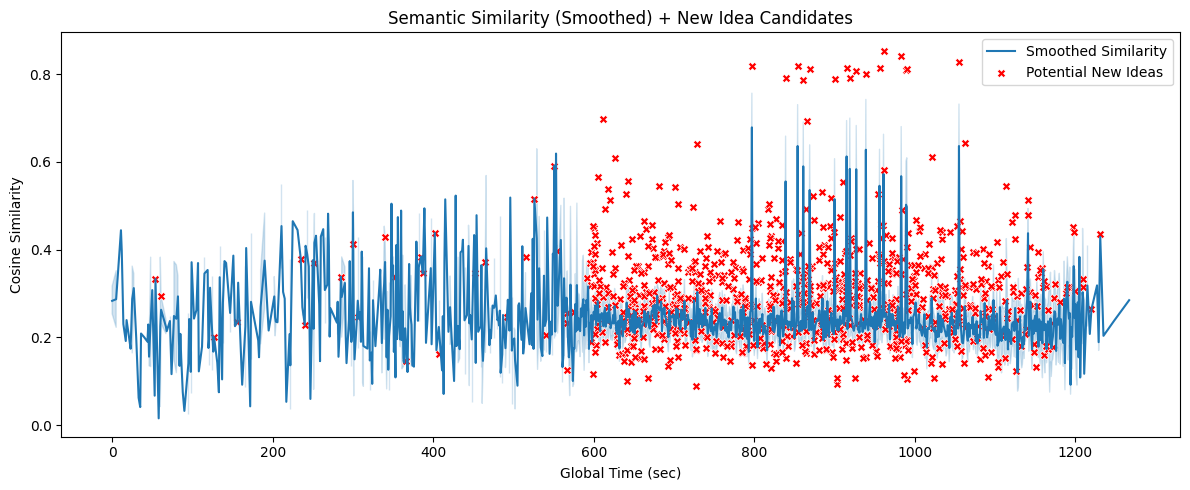

session
2021_09_30_MZT_S7     425
2021_05_20_ABI_S8     326
2021_06_10_SLU_S4     305
2021_05_21_ABI_S5     298
2021_05_21_ABI_S6     288
                     ... 
2021_04_23_MND_S16     52
2021_09_30_MZT_S6      39
2021_04_23_MND_S9      37
2021_04_22_MND_S8      31
2021_04_22_MND_S2       1
Name: count, Length: 82, dtype: int64


In [10]:
import platform
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util

# 1. Detect machine + load correct file
hostname = platform.node()

if "localdomain" in hostname:  # Mac Studio
    data_path = Path("/Users/maxchalekson/Projects/NICO-Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv")
else:  # MacBook Pro
    data_path = Path("/Users/maxchalekson/Northwestern University/Summer 2025/NICO/NICO Research/NICO_human-gemini/Data/utterance_data_aligned_full.csv")

print(f"Loading from: {data_path}")
df = pd.read_csv(data_path)

# 2. Filter for non-empty transcripts
df = df[df['transcript'].notnull()].reset_index(drop=True)

# 3. Load SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# 4. Compute sentence embeddings
embeddings = model.encode(df['transcript'].tolist(), convert_to_tensor=True)

# 5. Cosine similarity between adjacent utterances
similarities = [util.cos_sim(embeddings[i], embeddings[i+1]).item() for i in range(len(embeddings)-1)]
df['cosine_similarity_to_next'] = similarities + [np.nan]

# 6. Semantic shift + smoothing
df['similarity_diff'] = df['cosine_similarity_to_next'].diff()
df['potential_new_idea'] = df['similarity_diff'] < -0.4
df['similarity_smoothed'] = df['cosine_similarity_to_next'].rolling(window=5, min_periods=1).mean()
df['is_expanding'] = df['similarity_smoothed'] > 0.7
df['is_diverging'] = df['similarity_smoothed'] < 0.3

# 7. Plot smoothed similarity with new idea candidates
plt.figure(figsize=(12, 5))
sns.lineplot(x=df['global_timestamp_sec'], y=df['similarity_smoothed'], label="Smoothed Similarity")
sns.scatterplot(x=df[df['potential_new_idea']]['global_timestamp_sec'],
                y=df[df['potential_new_idea']]['similarity_smoothed'],
                color='red', label='Potential New Ideas', marker='X')
plt.title("Semantic Similarity (Smoothed) + New Idea Candidates")
plt.xlabel("Global Time (sec)")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.tight_layout()
plt.show()

# 8. Optional: See session distribution
print(df['session'].value_counts())

# 9. Optional: Export moments
df[df['potential_new_idea']][['session', 'speaker', 'global_timestamp_sec', 'transcript']].to_csv("new_idea_candidates.csv", index=False)


But then, for future note, how can I tell that SBERT is in fact making a difference, even if right now in the ipynb we are just looking at the 'potential new ideas' component code.

Because again, in the final code book, remember, we are using a combination of features to get the convergence/divergence towards a solution in a particular session b/w 7-8 researchers.

### Looking at one particular session from conference for e.g.

2021_09_30_MZT_S7

(will scale up later if all this works out... somehow)

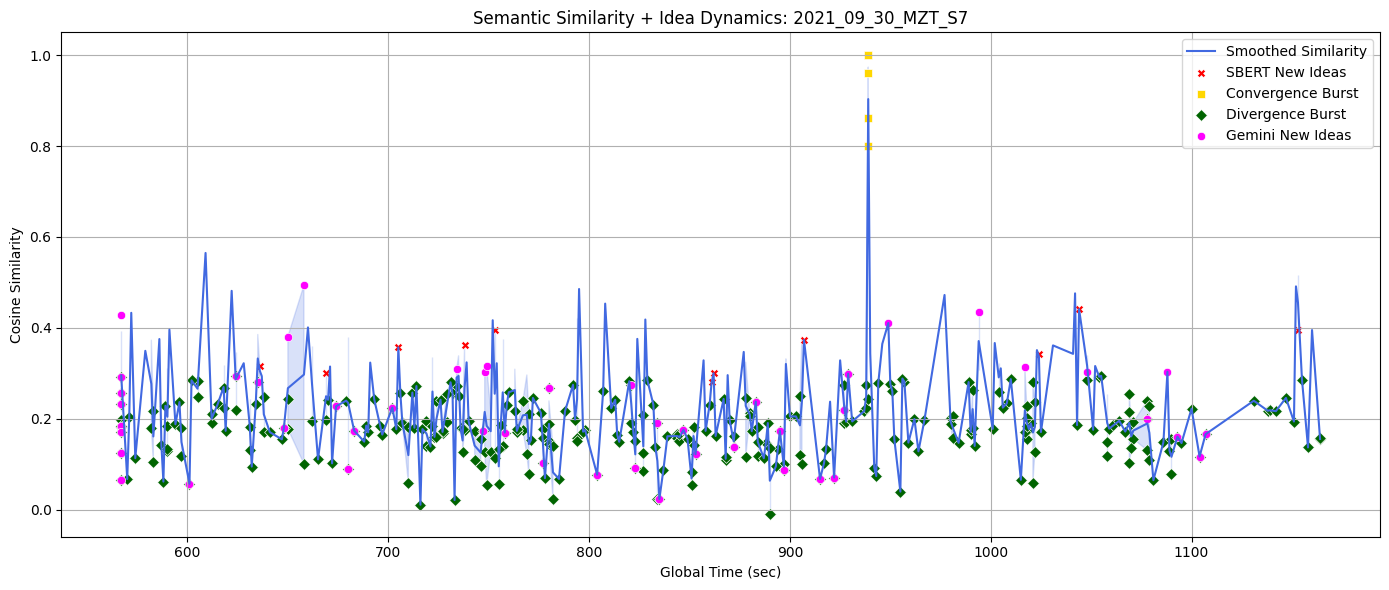

In [31]:
# Plot everything with color-legend alignment
plt.figure(figsize=(14, 6))

# Smoothed similarity (BLUE line)
sns.lineplot(
    x=df_one['global_timestamp_sec'],
    y=df_one['similarity_smoothed'],
    label="Smoothed Similarity",
    color='royalblue'
)

# SBERT-based potential new ideas (RED X)
sns.scatterplot(
    x=df_one[df_one['potential_new_idea']]['global_timestamp_sec'],
    y=df_one[df_one['potential_new_idea']]['similarity_smoothed'],
    color='red', label='SBERT New Ideas', marker='X'
)

# Convergence bursts (GOLD squares)
sns.scatterplot(
    x=df_one[df_one['in_valid_burst']]['global_timestamp_sec'],
    y=df_one[df_one['in_valid_burst']]['similarity_smoothed'],
    color='gold', label='Convergence Burst', marker='s'
)

# Divergence bursts (DARK GREEN diamonds)
sns.scatterplot(
    x=df_one[df_one['in_divergence_burst']]['global_timestamp_sec'],
    y=df_one[df_one['in_divergence_burst']]['similarity_smoothed'],
    color='darkgreen', label='Divergence Burst', marker='D'
)

# Gemini-coded new ideas (MAGENTA circles)
sns.scatterplot(
    x=df_one[df_one['gemini_new_idea']]['global_timestamp_sec'],
    y=df_one[df_one['gemini_new_idea']]['similarity_smoothed'],
    color='magenta', label='Gemini New Ideas', marker='o'
)

plt.title("Semantic Similarity + Idea Dynamics: 2021_09_30_MZT_S7")
plt.xlabel("Global Time (sec)")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### How Semantic Convergence and Divergence Bursts Are Calculated

The chart above visualizes semantic dynamics across the team meeting session `2021_09_30_MZT_S7`. It blends SBERT-based sentence embeddings with Gemini behavioral annotations to reveal when new ideas emerge, how they are elaborated, and where alignment or divergence happens.

- **Blue Line (Smoothed Similarity)**  
  A rolling average of cosine similarity between adjacent utterances (window = 5), computed from SBERT sentence embeddings. Higher values indicate that utterances are more semantically similar — a proxy for alignment or elaboration.

- **Red X’s (SBERT New Ideas)**  
  Moments of sharp semantic divergence (similarity drops > 0.4 compared to the prior utterance). These are hypothesized new idea moments based on linguistic novelty, even if they aren’t behaviorally marked.

- **Gold Squares (Convergence Bursts)**  
  Stretches of 3+ consecutive utterances with smoothed similarity > 0.75. These indicate sustained semantic alignment — likely periods of elaboration, agreement, or co-development of an idea.

- **Dark Green Diamonds (Divergence Bursts)**  
  Stretches of 3+ consecutive utterances with smoothed similarity < 0.3. These may reflect topic shifts, disagreements, or conceptual fragmentation.

- **Magenta Dots (Gemini New Ideas)**  
  Utterances labeled as “new idea” by Gemini’s behavioral coding system — often based on cues like tone, timing, and interaction dynamics.

Together, these signals allow us to track not only *when* a new idea emerges, but *how it flows*, *who aligns with it*, and *whether it leads to convergence or fragmentation*.


**Question:**

But then from the 3+ or the gold squares, does that mean we've converged to a solution that is in sight?

But also noticing for this convergent burst in the graph, it looks to occur at the 75% minute mark? Could they find solution at this point in the meeting?

- Not necessarily. Because remember, teams may peak early, diverge again, and re-converge later?


So then given this pattern of potential peak early, diverge again, and re-converge later, then what is the best move from here?

## Modeling the Convergence Arc Over Time

Trying to see if the convergence spikes tell something about the solutions, then.

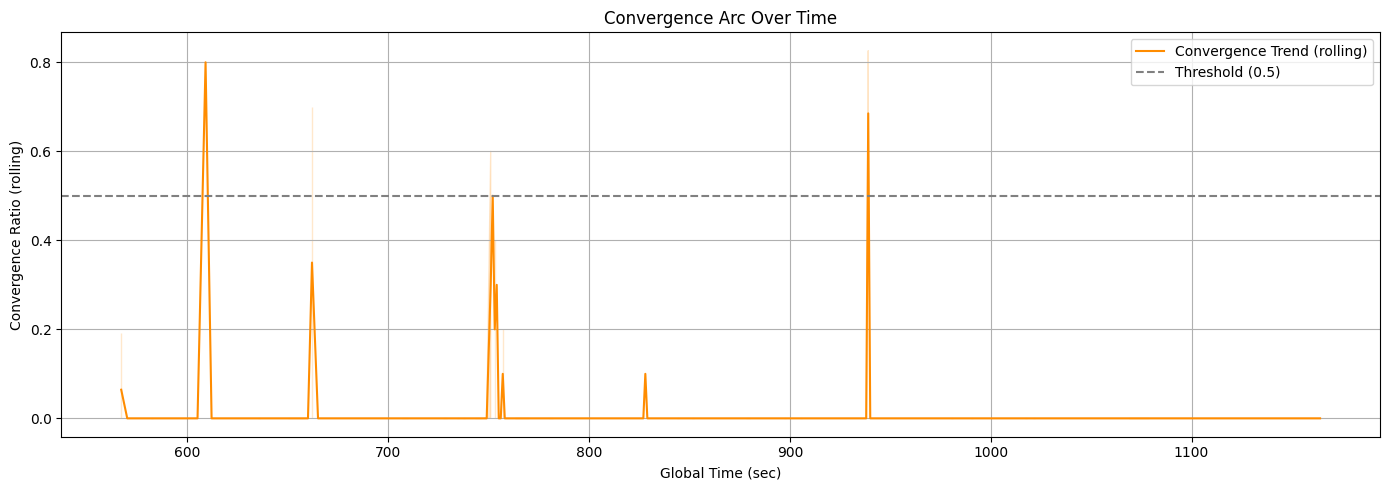

In [18]:
# Compute rolling window of convergence presence
window_size = 10  # You can tune this for more or less smoothing
df_one['running_convergence_ratio'] = df_one['in_valid_burst'].rolling(window=window_size, min_periods=1).mean()

# Plot convergence arc trend
plt.figure(figsize=(14, 5))
sns.lineplot(x=df_one['global_timestamp_sec'], y=df_one['running_convergence_ratio'], color='darkorange', label='Convergence Trend (rolling)')
plt.axhline(y=0.5, color='gray', linestyle='--', label='Threshold (0.5)')
plt.title("Convergence Arc Over Time")
plt.xlabel("Global Time (sec)")
plt.ylabel("Convergence Ratio (rolling)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Checking the 950 second mark of a Single Idea

b/c this is much later into the session. 
there's no convergence burst after this moment in the graph.

Again, this is for this session at a conference in particular ... so then the actual solution can still very much vary.



## Tracing Idea Dynamics: Who Introduces and Who Expands?

🔍 Who tends to expand on ideas?
followup_speaker
Adela Oliva Chavez    1
Kim Pepin             1
Lauren Charles        1
Liliana Salvador      1
Linda Detwiler        1
dtype: int64

🔍 Who expands on whose ideas?
idea_speaker   followup_speaker  
Crystal Hepp   Adela Oliva Chavez    1
               Kim Pepin             1
               Linda Detwiler        1
Kezia Manlove  Liliana Salvador      1
Mike Wimberly  Lauren Charles        1
dtype: int64


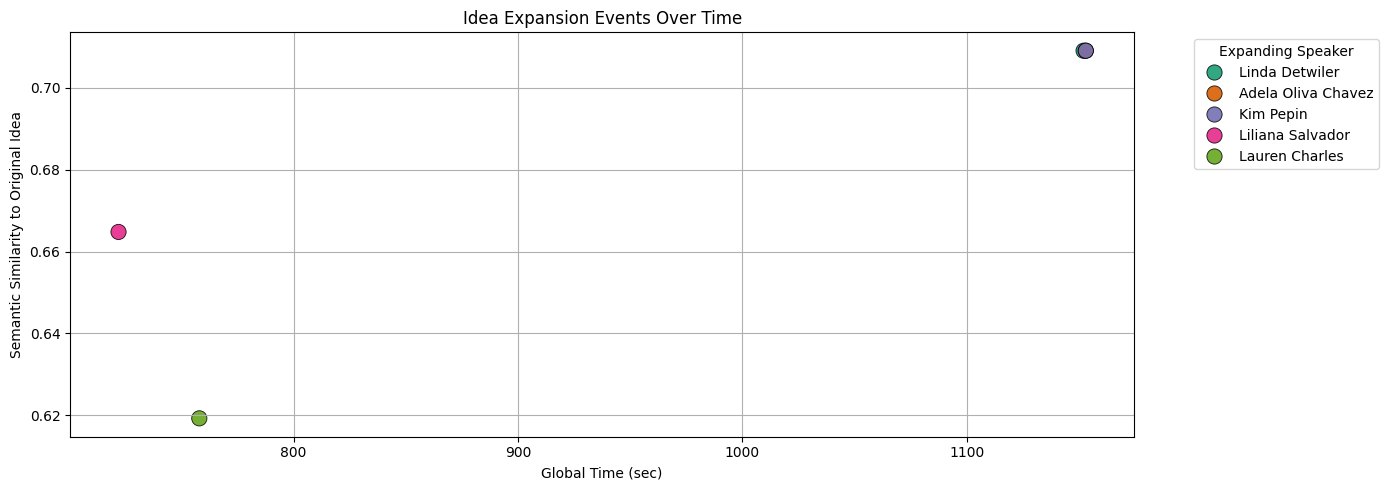

In [20]:
# Parameters
window = 5  # How many utterances after a new idea to consider as follow-up

# Create list of indices where new ideas are introduced
idea_rows = df_one[df_one['potential_new_idea']].index.tolist()

# Initialize list to hold expansion events
idea_expansion_events = []

# Loop through each new idea
for idea_idx in idea_rows:
    idea_text = df_one.loc[idea_idx, 'transcript']
    idea_embed = model.encode(idea_text, convert_to_tensor=True)

    for offset in range(1, window + 1):
        follow_idx = idea_idx + offset
        if follow_idx >= len(df_one):
            break  # Avoid index error
        follow_text = df_one.loc[follow_idx, 'transcript']
        follow_embed = model.encode(follow_text, convert_to_tensor=True)

        similarity = util.cos_sim(idea_embed, follow_embed).item()

        idea_expansion_events.append({
            'idea_idx': idea_idx,
            'idea_time': df_one.loc[idea_idx, 'global_timestamp_sec'],
            'idea_speaker': df_one.loc[idea_idx, 'speaker'],
            'followup_idx': follow_idx,
            'followup_time': df_one.loc[follow_idx, 'global_timestamp_sec'],
            'followup_speaker': df_one.loc[follow_idx, 'speaker'],
            'semantic_similarity': similarity,
        })

# Convert to DataFrame
idea_expansion_df = pd.DataFrame(idea_expansion_events)

# Filter to strong expansions
high_sim_followups = idea_expansion_df[idea_expansion_df['semantic_similarity'] > 0.6]

# Speaker-level expansion counts
print("🔍 Who tends to expand on ideas?")
print(high_sim_followups.groupby('followup_speaker').size().sort_values(ascending=False))

# Dyadic dynamics: Who builds on whose ideas
print("\n🔍 Who expands on whose ideas?")
print(high_sim_followups.groupby(['idea_speaker', 'followup_speaker']).size().sort_values(ascending=False))

# Timeline plot
plt.figure(figsize=(14, 5))
scatter = sns.scatterplot(
    data=high_sim_followups,
    x='followup_time',
    y='semantic_similarity',
    hue='followup_speaker',
    palette='Dark2',
    s=120,  # Bigger markers
    edgecolor='black',
    linewidth=0.6,
    alpha=0.9
)

# Optional: Annotate initials
# for _, row in high_sim_followups.iterrows():
#     plt.text(row['followup_time'], row['semantic_similarity'] + 0.01,
#              row['followup_speaker'].split()[-1], fontsize=8, ha='center')

plt.title("Idea Expansion Events Over Time")
plt.xlabel("Global Time (sec)")
plt.ylabel("Semantic Similarity to Original Idea")
plt.grid(True)
plt.legend(title="Expanding Speaker", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


So then from here could do the following (likely listed in personal priority):

1. Visual Convergence + Expansion Together 

Overlay convergence arcs + idea expansions in one plot. To see when expansions cluster inside convergence arcs, and who is contributing

2. Speaker Role Analysis

Could do a speaker taxonomy role 
(e.g.: new idea generator, expander, reframer, silent partner, simple counts - also work).
- Because then: some *very* future step would be to track individual people across different sessions / conferences (if they somehow go to multiple conference; but this far is unlikely).

3. Network Graph of Idea -- **this idea doesn't work.**

Visualizing the speakers as nodes - giving semantic interaction network over time.

Remember there's only 4-7 scientists per session.

4. Temporal Distance of Expansion

How long after a new idea do expansions happen? Are they immediate (w/in 5 utterances) or delayed (15+ utterances).
This could also tell about discussion structure.

## (1) When do expansions happen - do they align with convergence?

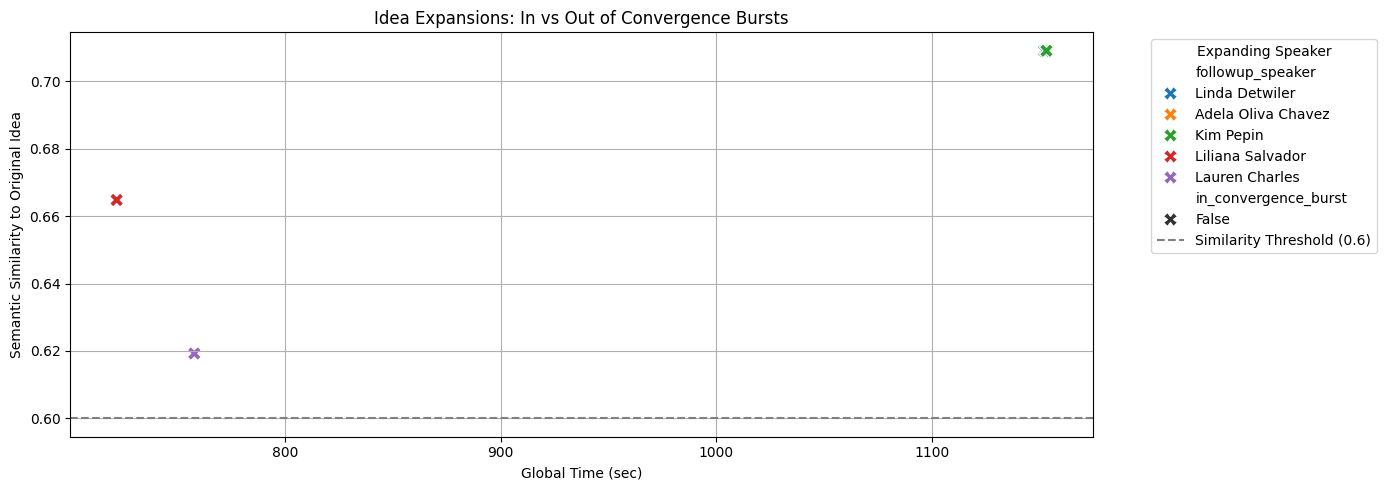

In [22]:
# --- Merge expansion events with convergence info ---
high_sim_followups = high_sim_followups.copy()
high_sim_followups['in_convergence_burst'] = high_sim_followups['followup_idx'].map(
    df_one['in_valid_burst']
)

# --- Timeline plot: idea expansions with convergence context ---
plt.figure(figsize=(14, 5))
sns.scatterplot(
    x=high_sim_followups['followup_time'],
    y=high_sim_followups['semantic_similarity'],
    hue=high_sim_followups['followup_speaker'],
    style=high_sim_followups['in_convergence_burst'],
    palette='tab10',
    s=100,
    markers={True: 'o', False: 'X'}
)

plt.axhline(y=0.6, color='gray', linestyle='--', label='Similarity Threshold (0.6)')
plt.title("Idea Expansions: In vs Out of Convergence Bursts")
plt.xlabel("Global Time (sec)")
plt.ylabel("Semantic Similarity to Original Idea")
plt.legend(title="Expanding Speaker", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## visual convergence + expansion

In [25]:
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Load SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Recompute embeddings
embeddings = model.encode(df['transcript'].tolist(), convert_to_tensor=True)

# Compute cosine similarity between consecutive utterances
similarities = [util.cos_sim(embeddings[i], embeddings[i+1]).item() for i in range(len(embeddings)-1)]
df['cosine_similarity_to_next'] = similarities + [np.nan]

# ---- ADDITIONAL PROCESSING FOR CONVERGENCE + EXPANSION ---- #

# (1) Flag expansions based on Gemini annotations
# Assuming has_new_idea and has_explanation columns exist (bool or 0/1)
df['is_expansion'] = df['has_new_idea'].fillna(False) | df['has_explanation'].fillna(False)

# (2) Flag convergence arcs using cosine similarity threshold
CONVERGENCE_THRESHOLD = 0.6  # tweakable
df['is_converging'] = df['cosine_similarity_to_next'] > CONVERGENCE_THRESHOLD

# Optional: Confirm counts
print(f"Total utterances: {len(df)}")
print(f"Expansions flagged: {df['is_expansion'].sum()}")
print(f"Convergence arcs flagged: {df['is_converging'].sum()}")



Total utterances: 16414
Expansions flagged: 3804
Convergence arcs flagged: 1253


For this session + conference in particular (2021_09_30_MZT_S7):

~23% of utternaces are expansions
~7.6% of utterances mark convergence arcs.

## (2) Speaker Role Analysis

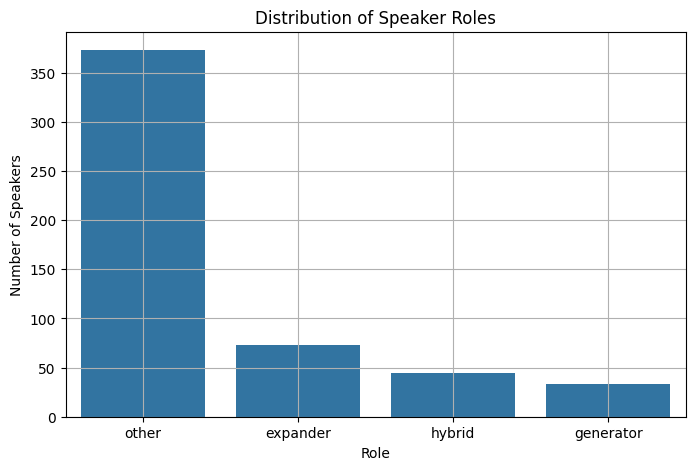

                speaker  total_utterances  new_ideas  expansions  idea_ratio  \
320    Lisa Kaltenegger               257         29          23    0.112840   
72           Brad Smith               220         16          16    0.072727   
75          Brian Pogue               206          8          19    0.038835   
384      Niki Parenteau               193          2          19    0.010363   
131    Dimitar Sasselov               191         11          24    0.057592   
..                  ...               ...        ...         ...         ...   
174            Haike Qi                 1          0           0    0.000000   
394            Paul Hsu                 1          0           0    0.000000   
186                 Jae                 1          0           0    0.000000   
192        Jamie Bender                 1          0           0    0.000000   
369  Michael D Cullinan                 1          0           0    0.000000   

     expansion_ratio   role  
320      

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count how many of each role
plt.figure(figsize=(8, 5))
sns.countplot(data=speaker_stats, x='role', order=speaker_stats['role'].value_counts().index)
plt.title("Distribution of Speaker Roles")
plt.xlabel("Role")
plt.ylabel("Number of Speakers")
plt.grid(True)
plt.show()

# Count speaker stats
speaker_stats = df.groupby('speaker').agg(
    total_utterances=('transcript', 'count'),
    new_ideas=('has_new_idea', 'sum'),
    expansions=('has_explanation', 'sum')
).reset_index()

# Add ratio columns
speaker_stats['idea_ratio'] = speaker_stats['new_ideas'] / speaker_stats['total_utterances']
speaker_stats['expansion_ratio'] = speaker_stats['expansions'] / speaker_stats['total_utterances']

# Classify speaker roles
def classify_role(row):
    if row['idea_ratio'] > 0.3 and row['expansion_ratio'] < 0.2:
        return "generator"
    elif row['expansion_ratio'] > 0.3 and row['idea_ratio'] < 0.2:
        return "expander"
    elif row['idea_ratio'] > 0.2 and row['expansion_ratio'] > 0.2:
        return "hybrid"
    else:
        return "other"

speaker_stats['role'] = speaker_stats.apply(classify_role, axis=1)

# Optional: view the results
print(speaker_stats.sort_values(by='total_utterances', ascending=False))




But with all of this:

- I am able to figure out the points of convergences (and by contrast, divergences).


BUT ---- THIS IS STILL THE ISSUE THAT I AM HAVING AT THIS POINT IN THE IPYNB

- do these "major points of convergences" actually lead to a point of solution. 

Take note that - in fact - not all convergences are created equal.

- AND, can this be backed by the transcript (or something similar)?



So, given all this - at this point in the ipynb:

Should I send my notebook to Evey with all of the progress.

OR

I can look up another piece of literature on "How do we know if convergence leads to a meaningful outcome or solution?"

**I can try searching up these paper topics:**

"Decision-making in team science meetings"

"Language markers of scientific insight"

"Convergence and knowledge creation in collaborative work"

"Discourse patterns in consensus-building"

"Linguistic indicators of innovation in teams"